In [1]:
# Analyzing Suicide Trends in the Philippines using PySpark (1979-2016)
# Kaggle Data Set: WHO Suicide Statistics: https://www.kaggle.com/datasets/szamil/who-suicide-statistics/data
# Basic historical (1979-2016) data by country, year and demographic groups 

In [2]:
# Import libraries
from pyspark.sql import SparkSession
import csv
from io import StringIO
from pyspark.sql.functions import col, when, format_number, desc
from pyspark.sql.functions import sum, count, avg, round, regexp_extract

In [3]:
# Create a SparkSession and Spark Context
spark = SparkSession.builder.appName("Philippine_Suicide_Data_Analysis").getOrCreate()
sc = spark.sparkContext

In [4]:
# DATA DICTIONARY
data_df = spark.read.csv("who_suicide_statistics.csv", header=True, inferSchema=True)
data_df.printSchema()

num_rows = data_df.count()
columns = data_df.columns
num_columns = len(columns)

print("Data Dictionary")
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

null_counts = {col_name: data_df.where(col(col_name).isNull()).count() for col_name in data_df.columns}
for col_name, null_count in null_counts.items():
    print(f"Column '{col_name}': {null_count} null values")

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)

Data Dictionary
Number of rows: 43776
Number of columns: 6
Column 'country': 0 null values
Column 'year': 0 null values
Column 'sex': 0 null values
Column 'age': 0 null values
Column 'suicides_no': 2256 null values
Column 'population': 5460 null values


In [5]:
# RDD Data Manipulation
rdd = sc.textFile("who_suicide_statistics.csv")
print(f"first elements of the rdd: {rdd.first()}")
print(f"number of elements of the rdd: {rdd.count()}")

first elements of the rdd: country,year,sex,age,suicides_no,population
number of elements of the rdd: 43777


In [6]:
# Remove header
header = rdd.first() 
data_rdd = rdd.filter(lambda row: row != header)
print(f"first elements of the rdd after removing the header: {data_rdd.first()}")
print(f"number of elements of the rdd after removing the header: {data_rdd.count()}")

first elements of the rdd after removing the header: Albania,1985,female,15-24 years,,277900
number of elements of the rdd after removing the header: 43776


In [7]:
# Helper function to parse a CSV row.
def parse_csv(row):
    reader = csv.DictReader(StringIO(row), fieldnames=header.split(','))
    return next(reader)

# Parse each row into a dictionary
parsed_rdd = data_rdd.map(parse_csv)

# Filter the dataset for rows where the country is 'Philippines'
philippines_rdd = parsed_rdd.filter(lambda row: row['country'] == 'Philippines')

In [8]:
# Using collect() method
print(philippines_rdd.collect())

[{'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '15-24 years', 'suicides_no': '', 'population': '5015000'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '25-34 years', 'suicides_no': '', 'population': '3417900'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '35-54 years', 'suicides_no': '', 'population': '3865100'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '5-14 years', 'suicides_no': '', 'population': '6017800'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '55-74 years', 'suicides_no': '', 'population': '1732900'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '75+ years', 'suicides_no': '', 'population': '264600'}, {'country': 'Philippines', 'year': '1980', 'sex': 'male', 'age': '15-24 years', 'suicides_no': '', 'population': '4907900'}, {'country': 'Philippines', 'year': '1980', 'sex': 'male', 'age': '25-34 years', 'suicides_no': '', 'population': '31

In [9]:
# Using take() method
print(philippines_rdd.take(10))

[{'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '15-24 years', 'suicides_no': '', 'population': '5015000'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '25-34 years', 'suicides_no': '', 'population': '3417900'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '35-54 years', 'suicides_no': '', 'population': '3865100'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '5-14 years', 'suicides_no': '', 'population': '6017800'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '55-74 years', 'suicides_no': '', 'population': '1732900'}, {'country': 'Philippines', 'year': '1980', 'sex': 'female', 'age': '75+ years', 'suicides_no': '', 'population': '264600'}, {'country': 'Philippines', 'year': '1980', 'sex': 'male', 'age': '15-24 years', 'suicides_no': '', 'population': '4907900'}, {'country': 'Philippines', 'year': '1980', 'sex': 'male', 'age': '25-34 years', 'suicides_no': '', 'population': '31

In [10]:
# Empty suicides number rows
empty_suicides_no_rdd = philippines_rdd.filter(lambda row: row['suicides_no'] == '')
print(f"empty suicide number rows count: {empty_suicides_no_rdd.count()}")

empty suicide number rows count: 96


In [11]:
# Filter rows with no null or empty string values
philippines_rdd = philippines_rdd.filter(lambda d: all(v not in (None, '') for v in d.values()))
empty_suicides_no_rdd = philippines_rdd.filter(lambda row: row['suicides_no'] == '')
print(f"empty suicide number rows count: {empty_suicides_no_rdd.count()}")

empty suicide number rows count: 0


In [12]:
# Group By
grouped_by_age_rdd = philippines_rdd.groupBy(lambda row: row['age'])
grouped_by_age_rdd = grouped_by_age_rdd.map(lambda x: (x[0], list(x[1])))
flattened_rdd = grouped_by_age_rdd.flatMap(lambda x: [(x[0], entry) for entry in x[1]])

# Compute suicide rates
suicide_rates_rdd = flattened_rdd.map(lambda x: (
    x[0],  # age group
    float(x[1]['suicides_no']) / float(x[1]['population']) * 100000  # suicide rate per 100,000
))

# Aggregate by age group, calculate average suicide rate per age group 
# using formula: Suicide rate = Total Number of suicides per Age Group / Total Population per Age Group) × 100,000

aggregated_rdd = suicide_rates_rdd.combineByKey(
    lambda value: (value, 1),
    lambda acc, value: (acc[0] + value, acc[1] + 1),
    lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])
).map(lambda x: (x[0], x[1][0] / x[1][1]))

# Collect and print results
results = aggregated_rdd.collect()
for result in results:
    print(f"Age Group: {result[0]}, Average Suicide Rate: {result[1]:.2f}%")

Age Group: 15-24 years, Average Suicide Rate: 2.84%
Age Group: 5-14 years, Average Suicide Rate: 0.16%
Age Group: 55-74 years, Average Suicide Rate: 2.46%
Age Group: 75+ years, Average Suicide Rate: 4.04%
Age Group: 25-34 years, Average Suicide Rate: 2.78%
Age Group: 35-54 years, Average Suicide Rate: 2.24%


In [13]:
# Sort by suicide rate in descending order
sorted_rdd = aggregated_rdd.sortBy(lambda x: x[1], ascending=False)
results = sorted_rdd.collect()
for result in results:
    print(f"Age Group: {result[0]}, Average Suicide Rate: {result[1]:.2f}%")

Age Group: 75+ years, Average Suicide Rate: 4.04%
Age Group: 15-24 years, Average Suicide Rate: 2.84%
Age Group: 25-34 years, Average Suicide Rate: 2.78%
Age Group: 55-74 years, Average Suicide Rate: 2.46%
Age Group: 35-54 years, Average Suicide Rate: 2.24%
Age Group: 5-14 years, Average Suicide Rate: 0.16%


In [14]:
# Dataframe Data Manipulation
df = spark.read.csv("who_suicide_statistics.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)



In [15]:
# Show the first few rows of the DataFrame
print("Before dropping nulls:")
df.show()

Before dropping nulls:
+-------+----+------+-----------+-----------+----------+
|country|year|   sex|        age|suicides_no|population|
+-------+----+------+-----------+-----------+----------+
|Albania|1985|female|15-24 years|       NULL|    277900|
|Albania|1985|female|25-34 years|       NULL|    246800|
|Albania|1985|female|35-54 years|       NULL|    267500|
|Albania|1985|female| 5-14 years|       NULL|    298300|
|Albania|1985|female|55-74 years|       NULL|    138700|
|Albania|1985|female|  75+ years|       NULL|     34200|
|Albania|1985|  male|15-24 years|       NULL|    301400|
|Albania|1985|  male|25-34 years|       NULL|    264200|
|Albania|1985|  male|35-54 years|       NULL|    296700|
|Albania|1985|  male| 5-14 years|       NULL|    325800|
|Albania|1985|  male|55-74 years|       NULL|    132500|
|Albania|1985|  male|  75+ years|       NULL|     21100|
|Albania|1986|female|15-24 years|       NULL|    283900|
|Albania|1986|female|25-34 years|       NULL|    252100|
|Albania

In [16]:
# Drop rows where any of the specified columns have null values
columns_to_check = df.columns
cleaned_df = df.dropna(subset=columns_to_check)
print("After dropping nulls:")
cleaned_df.show()

After dropping nulls:
+-------+----+------+-----------+-----------+----------+
|country|year|   sex|        age|suicides_no|population|
+-------+----+------+-----------+-----------+----------+
|Albania|1987|female|15-24 years|         14|    289700|
|Albania|1987|female|25-34 years|          4|    257200|
|Albania|1987|female|35-54 years|          6|    278800|
|Albania|1987|female| 5-14 years|          0|    311000|
|Albania|1987|female|55-74 years|          0|    144600|
|Albania|1987|female|  75+ years|          1|     35600|
|Albania|1987|  male|15-24 years|         21|    312900|
|Albania|1987|  male|25-34 years|          9|    274300|
|Albania|1987|  male|35-54 years|         16|    308000|
|Albania|1987|  male| 5-14 years|          0|    338200|
|Albania|1987|  male|55-74 years|          1|    137500|
|Albania|1987|  male|  75+ years|          1|     21800|
|Albania|1988|female|15-24 years|          8|    295600|
|Albania|1988|female|25-34 years|          5|    262400|
|Albania|

In [17]:
# Show the first few rows of the DataFrame before filtering
print("Before filtering:")
cleaned_df.show()

Before filtering:
+-------+----+------+-----------+-----------+----------+
|country|year|   sex|        age|suicides_no|population|
+-------+----+------+-----------+-----------+----------+
|Albania|1987|female|15-24 years|         14|    289700|
|Albania|1987|female|25-34 years|          4|    257200|
|Albania|1987|female|35-54 years|          6|    278800|
|Albania|1987|female| 5-14 years|          0|    311000|
|Albania|1987|female|55-74 years|          0|    144600|
|Albania|1987|female|  75+ years|          1|     35600|
|Albania|1987|  male|15-24 years|         21|    312900|
|Albania|1987|  male|25-34 years|          9|    274300|
|Albania|1987|  male|35-54 years|         16|    308000|
|Albania|1987|  male| 5-14 years|          0|    338200|
|Albania|1987|  male|55-74 years|          1|    137500|
|Albania|1987|  male|  75+ years|          1|     21800|
|Albania|1988|female|15-24 years|          8|    295600|
|Albania|1988|female|25-34 years|          5|    262400|
|Albania|1988

In [18]:
# Filter
# Filter the DataFrame to only include rows where the country is "Philippines"
filtered_df = cleaned_df.dropDuplicates().filter(df['country'] == 'Philippines')
print("After filtering for Philippines:")
filtered_df.show()

After filtering for Philippines:
+-----------+----+------+-----------+-----------+----------+
|    country|year|   sex|        age|suicides_no|population|
+-----------+----+------+-----------+-----------+----------+
|Philippines|1993|female|  75+ years|         10|    395945|
|Philippines|2006|female| 5-14 years|         28|  10121349|
|Philippines|2002|female|15-24 years|        114|   7903007|
|Philippines|1992|female|  75+ years|          2|    385751|
|Philippines|2008|  male|55-74 years|        144|   3349085|
|Philippines|1993|female|35-54 years|         54|   5754827|
|Philippines|1993|  male| 5-14 years|          0|   8673303|
|Philippines|1999|  male|25-34 years|        199|   5840463|
|Philippines|2009|  male|25-34 years|        383|   7144648|
|Philippines|2002|  male|25-34 years|        267|   6171400|
|Philippines|2000|  male|35-54 years|        294|   7449254|
|Philippines|2002|  male|55-74 years|         93|   2525030|
|Philippines|2010|  male|25-34 years|        400|   

In [19]:
# Add column called suicide rate
# using formula: Suicide rate = ( suicides number / population ) × 100,000

filtered_df = filtered_df.withColumn("suicide_rate", (col("suicides_no") / col("population")) * 100000 )
filtered_df = filtered_df.withColumn("suicide_rate", format_number("suicide_rate", 2))
filtered_df.show()

+-----------+----+------+-----------+-----------+----------+------------+
|    country|year|   sex|        age|suicides_no|population|suicide_rate|
+-----------+----+------+-----------+-----------+----------+------------+
|Philippines|1993|female|  75+ years|         10|    395945|        2.53|
|Philippines|2006|female| 5-14 years|         28|  10121349|        0.28|
|Philippines|2002|female|15-24 years|        114|   7903007|        1.44|
|Philippines|1992|female|  75+ years|          2|    385751|        0.52|
|Philippines|2008|  male|55-74 years|        144|   3349085|        4.30|
|Philippines|1993|female|35-54 years|         54|   5754827|        0.94|
|Philippines|1993|  male| 5-14 years|          0|   8673303|        0.00|
|Philippines|1999|  male|25-34 years|        199|   5840463|        3.41|
|Philippines|2009|  male|25-34 years|        383|   7144648|        5.36|
|Philippines|2002|  male|25-34 years|        267|   6171400|        4.33|
|Philippines|2000|  male|35-54 years| 

In [20]:
# Select Distinct Age Groups

select_age_groups_df = filtered_df.select("age").distinct()
select_age_groups_df.show()

+-----------+
|        age|
+-----------+
|55-74 years|
|25-34 years|
| 5-14 years|
|  75+ years|
|15-24 years|
|35-54 years|
+-----------+



In [21]:
# Group By Age

# Cast the 'suicides_no' column to integers, 'suicide_rate' column to float (or double)
filtered_df = filtered_df.withColumn('suicides_no', col('suicides_no').cast('integer'))
filtered_df = filtered_df.withColumn('suicide_rate', col('suicide_rate').cast('double'))

# Group by the 'age' column, sum the 'suicides_no' column, and get the average of the 'suicide_rate' column
grouped_by_age_df = filtered_df.groupBy('age').agg(
    sum('suicides_no').alias('total_suicides_no'),
    round(avg('suicide_rate'), 2).alias('average_suicide_rate')
)

grouped_by_age_df.show()

+-----------+-----------------+--------------------+
|        age|total_suicides_no|average_suicide_rate|
+-----------+-----------------+--------------------+
|55-74 years|             2168|                2.46|
|25-34 years|             5358|                2.78|
| 5-14 years|              493|                0.16|
|  75+ years|              488|                4.04|
|15-24 years|             7107|                2.84|
|35-54 years|             5716|                2.24|
+-----------+-----------------+--------------------+



In [22]:
# Order By "total_suicides_no" descending
grouped_by_age_df = grouped_by_age_df.orderBy("total_suicides_no", ascending=False)
print("Ordered age groups by most number of suicides")
grouped_by_age_df.show()

Ordered age groups by most number of suicides
+-----------+-----------------+--------------------+
|        age|total_suicides_no|average_suicide_rate|
+-----------+-----------------+--------------------+
|15-24 years|             7107|                2.84|
|35-54 years|             5716|                2.24|
|25-34 years|             5358|                2.78|
|55-74 years|             2168|                2.46|
| 5-14 years|              493|                0.16|
|  75+ years|              488|                4.04|
+-----------+-----------------+--------------------+



In [23]:
# Order By "average_suicide_rate" descending
grouped_by_age_df = grouped_by_age_df.orderBy("average_suicide_rate", ascending=False)
print("Ordered age groups by average suicide rate per 100 000 population")
grouped_by_age_df.show()

Ordered age groups by average suicide rate per 100 000 population
+-----------+-----------------+--------------------+
|        age|total_suicides_no|average_suicide_rate|
+-----------+-----------------+--------------------+
|  75+ years|              488|                4.04|
|15-24 years|             7107|                2.84|
|25-34 years|             5358|                2.78|
|55-74 years|             2168|                2.46|
|35-54 years|             5716|                2.24|
| 5-14 years|              493|                0.16|
+-----------+-----------------+--------------------+



In [24]:
# Group By sex

# Group by the 'sex' column, sum the 'suicides_no' column, and get the average of the 'suicide_rate' column
grouped_by_sex_df = filtered_df.groupBy('sex').agg(
    sum('suicides_no').alias('total_suicides_no'),
    round(avg('suicide_rate'), 2).alias('average_suicide_rate')
)

# Show the grouped DataFrame
grouped_by_sex_df.show()

+------+-----------------+--------------------+
|   sex|total_suicides_no|average_suicide_rate|
+------+-----------------+--------------------+
|female|             5273|                1.09|
|  male|            16057|                3.75|
+------+-----------------+--------------------+



In [25]:
# Order By "average_suicide_rate" descending
grouped_by_sex_df = grouped_by_sex_df.orderBy(col('average_suicide_rate').desc())
grouped_by_sex_df.show()

+------+-----------------+--------------------+
|   sex|total_suicides_no|average_suicide_rate|
+------+-----------------+--------------------+
|  male|            16057|                3.75|
|female|             5273|                1.09|
+------+-----------------+--------------------+



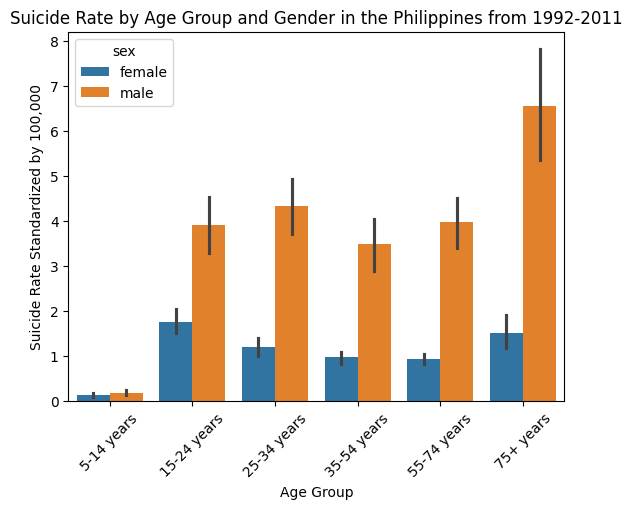

In [26]:
# Bar plot to compare suicide counts across age groups and genders
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to extract the lower bound of the age range
def extract_lower_bound(age_range):
    if age_range == '75+':
        return 75  # Return a specific value for "75+"
    else:
        return int(age_range.split('-')[0])
    
filtered_df_age_ordered = filtered_df.toPandas()

# Convert the 'age' column to numerical format
filtered_df_age_ordered['age_numeric'] = filtered_df_age_ordered['age'].apply(lambda x: extract_lower_bound(x.split()[0]))

# Order the DataFrame by the numerical age values in descending order
filtered_df_age_ordered = filtered_df_age_ordered.sort_values(by='age_numeric')

sns.barplot(data = filtered_df_age_ordered, x='age', y='suicide_rate', hue='sex')
plt.title('Suicide Rate by Age Group and Gender in the Philippines from 1992-2011')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.ylabel('Suicide Rate Standardized by 100,000')
plt.show()

In [27]:
# Group By year

# Group by the 'year' column, sum the 'suicides_no' column, and get the average of the 'suicide_rate' column
grouped_by_year_df = filtered_df.groupBy('year').agg(
    sum('suicides_no').alias('total_suicides_no'),
    round(avg('suicide_rate'), 2).alias('average_suicide_rate')
)

# Show the grouped DataFrame
grouped_by_year_df.show()

+----+-----------------+--------------------+
|year|total_suicides_no|average_suicide_rate|
+----+-----------------+--------------------+
|2003|             1544|                2.78|
|2007|             1698|                2.43|
|2006|             1788|                3.05|
|1997|              814|                1.69|
|1998|              883|                1.84|
|2009|             2074|                2.91|
|2001|             1204|                2.26|
|1992|              347|                0.82|
|2000|             1403|                2.68|
|2010|             2116|                3.08|
|2011|             2449|                3.74|
|2008|             1820|                2.75|
|1999|             1043|                2.07|
|2002|             1301|                2.38|
|1993|              846|                1.83|
+----+-----------------+--------------------+



In [28]:
# Order By year ascending
grouped_by_year_df = grouped_by_year_df.orderBy(col('year').desc())
grouped_by_year_df.show()

+----+-----------------+--------------------+
|year|total_suicides_no|average_suicide_rate|
+----+-----------------+--------------------+
|2011|             2449|                3.74|
|2010|             2116|                3.08|
|2009|             2074|                2.91|
|2008|             1820|                2.75|
|2007|             1698|                2.43|
|2006|             1788|                3.05|
|2003|             1544|                2.78|
|2002|             1301|                2.38|
|2001|             1204|                2.26|
|2000|             1403|                2.68|
|1999|             1043|                2.07|
|1998|              883|                1.84|
|1997|              814|                1.69|
|1993|              846|                1.83|
|1992|              347|                0.82|
+----+-----------------+--------------------+



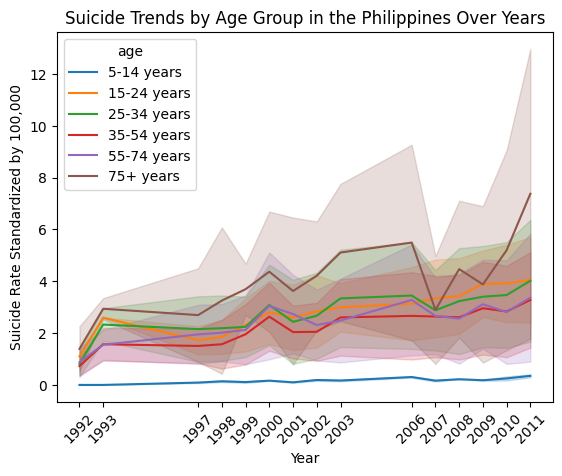

In [29]:
# Line plot
sns.lineplot(data=filtered_df_age_ordered, x='year', y='suicide_rate', hue='age')
plt.xticks(filtered_df_age_ordered['year'].unique(), rotation=45)
plt.title('Suicide Trends by Age Group in the Philippines Over Years')
plt.xlabel('Year')
plt.ylabel('Suicide Rate Standardized by 100,000')
plt.show()

In [30]:
# Questions
# 1. What age group has the highest suicide rate in the Philippines throughout the years?
# 2. Are Filipino men more likely to commit suicide than Filipino women?
# 3. In what year from 1992-2011 has the highest recorded number of suicide in the Philippines? lowest? ( with constraints for unavailable data)
# 4. In what year from 1992-2011 has the highest measured suicide rate in the Philippines? lowest? (with constraints for unavailable data)

In [31]:
# SQL Queries

# 1. What age group has the highest suicide rate in the Philippines throughout the years?

filtered_df.createOrReplaceTempView("temp_view1")
query_result = spark.sql("""
    SELECT age, ROUND(AVG(suicide_rate), 2) AS avg_suicide_rate
    FROM temp_view1
    WHERE country = 'Philippines'
    GROUP BY age
    ORDER BY avg_suicide_rate DESC
    LIMIT 1
""")
query_result.show()

+---------+----------------+
|      age|avg_suicide_rate|
+---------+----------------+
|75+ years|            4.04|
+---------+----------------+



In [32]:
# 2. Are Filipino men more likely to commit suicide than Filipino women? 

filtered_df.createOrReplaceTempView("temp_view2")
query_result = spark.sql("""
    SELECT sex, ROUND(AVG(suicide_rate), 2) AS avg_suicide_rate
    FROM temp_view2
    WHERE country = 'Philippines'
    GROUP BY sex
    ORDER BY avg_suicide_rate DESC
""")

# Show the result
query_result.show()

+------+----------------+
|   sex|avg_suicide_rate|
+------+----------------+
|  male|            3.75|
|female|            1.09|
+------+----------------+



In [33]:
# 3. In what year from 1992-2011 has the highest recorded number of suicide in the Philippines? lowest? ( with constraints for unavailable data)

# For the highest recorded number of suicides
filtered_df.createOrReplaceTempView("temp_view3")
query_result_highest = spark.sql("""
    SELECT year, SUM(suicides_no) AS total_suicides
    FROM temp_view3
    WHERE country = 'Philippines' AND year BETWEEN 1992 AND 2011
    GROUP BY year
    ORDER BY total_suicides DESC
    LIMIT 1
""")

print("The highest recorded number of suicide in the Philippines from 1992-2011")
query_result_highest.show()

# For the lowest recorded number of suicides
filtered_df.createOrReplaceTempView("temp_view4")
query_result_highest = spark.sql("""
    SELECT year, SUM(suicides_no) AS total_suicides
    FROM temp_view4
    WHERE country = 'Philippines' AND year BETWEEN 1992 AND 2011
    GROUP BY year
    ORDER BY total_suicides
    LIMIT 1
""")

print("The lowest recorded number of suicide in the Philippines from 1992-2011")
query_result_highest.show()


The highest recorded number of suicide in the Philippines from 1992-2011
+----+--------------+
|year|total_suicides|
+----+--------------+
|2011|          2449|
+----+--------------+

The lowest recorded number of suicide in the Philippines from 1992-2011
+----+--------------+
|year|total_suicides|
+----+--------------+
|1992|           347|
+----+--------------+



In [34]:
# 4. In what year from 1992-2011 has the highest measured suicide rate in the Philippines? lowest? (with constraints for unavailable data)

# For the highest recorded suicide rate
query_result_highest = spark.sql("""
    SELECT year, AVG(suicide_rate) AS avg_suicide_rate
    FROM temp_view3
    WHERE country = 'Philippines' AND year BETWEEN 1992 AND 2011
    GROUP BY year
    ORDER BY avg_suicide_rate DESC
    LIMIT 1
""")

print("The year with the highest recorded suicide rate in the Philippines from 1992-2011:")
query_result_highest.show()

# For the lowest recorded suicide rate
query_result_lowest = spark.sql("""
    SELECT year, AVG(suicide_rate) AS avg_suicide_rate
    FROM temp_view4
    WHERE country = 'Philippines' AND year BETWEEN 1992 AND 2011
    GROUP BY year
    ORDER BY avg_suicide_rate ASC
    LIMIT 1
""")

print("The year with the lowest recorded suicide rate in the Philippines from 1992-2011:")
query_result_lowest.show()

The year with the highest recorded suicide rate in the Philippines from 1992-2011:
+----+----------------+
|year|avg_suicide_rate|
+----+----------------+
|2011|          3.7425|
+----+----------------+

The year with the lowest recorded suicide rate in the Philippines from 1992-2011:
+----+----------------+
|year|avg_suicide_rate|
+----+----------------+
|1992|          0.8175|
+----+----------------+



In [35]:
spark.stop()